In [263]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
from scipy import signal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from numpy import inf
import random

%matplotlib inline

!pwd

/home/sebastian/experiments/aifnet_replication


In [2]:
#Reading an example PCT volume

In [3]:

keras.backend.set_image_data_format('channels_last')
ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training'
current_fold = 3
#At insel: /media/sebastian/data/ASAP/ISLES2018_Training
#Local: '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = ROOT_EXP + 'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43

#Reading AIFs and VOFs for each of the partitions
train_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/train.txt'
valid_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/valid.txt'
test_partition_path =  ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/test.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                        min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

ctp_volumes_train = read_isles_volumepaths_from_file_otf(root_dir, train_partition_path, aif_annotations_path)
ctp_volumes_valid = read_isles_volumepaths_from_file_otf(root_dir, valid_partition_path, aif_annotations_path)
ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)

print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))



67 67
7 7
20 20


In [4]:
train_datagen = ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                            annotations_vof=vof_annotations_train,minimum_number_volumes_ctp = 43, batch_size=1,
                                        time_arrival_augmentation = True, delay_t=0, normalize_hu=False)


In [285]:
example_id = 23
sample_pct = train_datagen.__getitem__(example_id)
pct_vals = sample_pct[0][0,:,:,:,:]
vascular_functions = sample_pct[1]
aif = vascular_functions[0]
vof = vascular_functions[1]

In [286]:
pct_vals.shape

(256, 256, 4, 43)

In [156]:
train_datagen.ctp_volumes

[{'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_3/SMIR.Brain.XX.O.CT_4DPWI.345575/SMIR.Brain.XX.O.CT_4DPWI.345575.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_4/SMIR.Brain.XX.O.CT_4DPWI.345582/SMIR.Brain.XX.O.CT_4DPWI.345582.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_5/SMIR.Brain.XX.O.CT_4DPWI.345589/SMIR.Brain.XX.O.CT_4DPWI.345589.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_6/SMIR.Brain.XX.O.CT_4DPWI.345596/SMIR.Brain.XX.O.CT_4DPWI.345596.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_7/SMIR.Brain.XX.O.CT_4DPWI.345603/SMIR.Brain.XX.O.CT_4DPWI

In [157]:
np.mean(pct_vals[:,:])

69.33016105207184

In [158]:
mu_voi = np.array([np.mean(pct_vals[:,:,:,i]) for i in range(pct_vals.shape[-1])])
print(mu_voi)
mu_voi.shape

[68.38684728 68.24207312 68.22214859 68.27184878 68.25011922 68.17246441
 68.24277275 68.17753491 68.38865785 68.34867732 68.18453833 68.28297118
 68.38927049 68.53475616 68.95997838 69.43725394 69.71600435 70.09033072
 70.3524773  70.46515669 70.56486146 70.68045166 70.4949343  70.58340154
 69.89935419 70.06806063 69.97601462 69.88919976 69.83488367 69.67284116
 69.69056851 69.74672229 69.33074055 69.58646007 69.56526752 69.55479919
 69.54781531 69.58347983 69.59045437 69.57639366 69.58611827 69.60500629
 69.4532146 ]


(43,)

In [159]:
np.argmin(mu_voi)

5

Text(0, 0.5, 'Normalized Density (HU)')

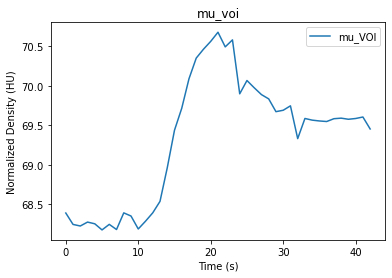

In [160]:
plt.title('mu_voi')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot(mu_voi)
#plt.plot(y_p)
#plt.plot(mu_voi)
plt.legend([ 'mu_VOI'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [161]:
np.argmax(np.abs(np.gradient(mu_voi)))

14

Text(0, 0.5, 'Normalized Density (HU)')

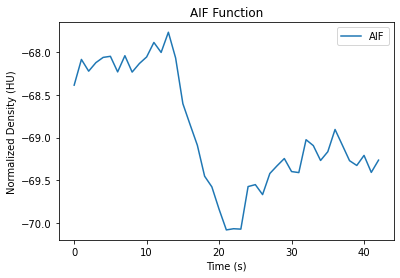

In [162]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot((aif)-(mu_voi))
#plt.plot(y_p)
#plt.plot(mu_voi)
plt.legend(['AIF','VOF', 'mu_VOI'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [163]:
A = np.multiply(np.tril(np.ones((aif.shape[0],aif.shape[0]))), circulant(aif))

In [164]:
A

array([[0.00063587, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15726979, 0.00063587, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15726979, 0.00063587, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.37736092, 0.24965049, 0.31959002, ..., 0.00063587, 0.        ,
        0.        ],
       [0.19717947, 0.37736092, 0.24965049, ..., 0.15726979, 0.00063587,
        0.        ],
       [0.18890158, 0.19717947, 0.37736092, ..., 0.        , 0.15726979,
        0.00063587]])

In [165]:
aif

array([6.35868741e-04, 1.57269786e-01, 0.00000000e+00, 1.49682305e-01,
       1.89146763e-01, 1.24299152e-01, 1.19949285e-02, 1.36499317e-01,
       1.55683175e-01, 2.16071236e-01, 1.28743467e-01, 3.97257742e-01,
       3.86721882e-01, 7.68487441e-01, 8.92013424e-01, 8.34272860e-01,
       8.66897000e-01, 1.00000000e+00, 9.00127873e-01, 8.87603814e-01,
       7.24256199e-01, 5.98689452e-01, 4.27044384e-01, 5.10822012e-01,
       3.25354082e-01, 5.16723923e-01, 3.08009111e-01, 4.68236527e-01,
       5.04387471e-01, 4.27118120e-01, 2.92318779e-01, 3.36513521e-01,
       3.05692321e-01, 4.92288981e-01, 2.96998571e-01, 3.89268395e-01,
       6.42625566e-01, 4.96150497e-01, 3.19590023e-01, 2.49650491e-01,
       3.77360919e-01, 1.97179468e-01, 1.88901575e-01])

In [166]:
u, s, vh = np.linalg.svd(A, full_matrices=True)

In [167]:
np.linalg.pinv(A)

array([[ 2.57077127e-02,  6.35829805e+00, -2.57072925e-02, ...,
        -6.55594520e-16, -1.73125079e-16,  1.66308398e-15],
       [-5.52015912e-06,  2.43424151e-02,  6.35830357e+00, ...,
         1.53546620e-15, -4.88477466e-16, -2.18733040e-16],
       [-2.43419937e-02, -6.02051978e+00,  4.86840109e-02, ...,
         1.08824371e-15,  4.35542560e-16, -2.48812518e-15],
       ...,
       [ 2.16304159e+02,  5.33701498e+04, -3.21775863e+04, ...,
         4.86840109e-02,  6.35830357e+00, -2.57072925e-02],
       [ 3.97780843e+02,  9.86011912e+04,  5.33701498e+04, ...,
        -6.02051978e+00,  2.43424151e-02,  6.35829805e+00],
       [ 1.60472703e+00,  3.97780843e+02,  2.16304159e+02, ...,
        -2.43419937e-02, -5.52013755e-06,  2.57077127e-02]])

In [168]:
truncation_vals = 3
S = np.diag(1/s)
S[-truncation_vals:,-truncation_vals:] = 0

In [169]:
A_inv = np.matmul(np.matmul(u,S), vh)

In [170]:
A_inv.shape

(43, 43)

In [171]:
pseudo_inv = scipy.linalg.pinv2(A)

In [172]:
k =  np.matmul(mu_voi,A_inv)

In [173]:
T_max = np.argmax(k)
print(T_max)

41


In [174]:
clf = Ridge(alpha=1.0)
clf.fit(A, mu_voi)
k_tik = clf.predict(A)

Text(0, 0.5, 'Normalized Density (HU)')

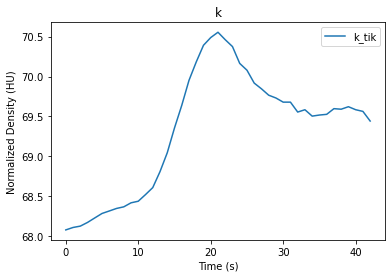

In [175]:
plt.title('k')        
#plt.plot(k)
plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

In [176]:
print(A.shape)
print(k_tik.shape)
print(k_tik.shape)
print(pct_vals.shape)
example_voi = pct_vals[100,100,0,:]
print(example_voi.shape)

(43, 43)
(43,)
(43,)
(256, 256, 2, 43)
(43,)


Text(0, 0.5, 'Normalized Density (HU)')

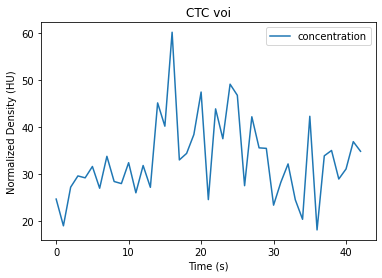

In [177]:
plt.title('CTC voi')        
#plt.plot(k)
plt.plot(example_voi)
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

Text(0, 0.5, 'Normalized Density (HU)')

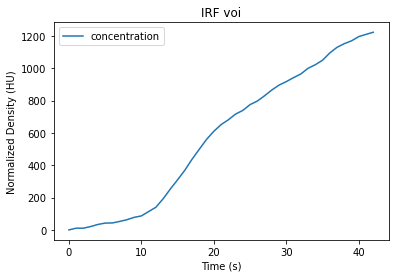

In [178]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [179]:
1/example_voi

array([0.04063494, 0.05288447, 0.03683341, 0.03385143, 0.03432205,
       0.03169378, 0.03714951, 0.02965459, 0.03527005, 0.03583019,
       0.03090121, 0.03854386, 0.0314858 , 0.03688139, 0.02217095,
       0.02490984, 0.01662031, 0.03034175, 0.02911903, 0.02606882,
       0.02108674, 0.04082568, 0.02281304, 0.02668703, 0.02036839,
       0.02140192, 0.03641323, 0.02372399, 0.02814803, 0.02823564,
       0.04289729, 0.03549273, 0.03115219, 0.04089174, 0.04926583,
       0.02366725, 0.05545057, 0.02955856, 0.02859693, 0.03461992,
       0.03223427, 0.02714009, 0.02874341])

In [180]:
np.max(np.matmul(A,k_tik)/(1/example_voi))

44579.47811229127

Text(0, 0.5, 'Normalized Density (HU)')

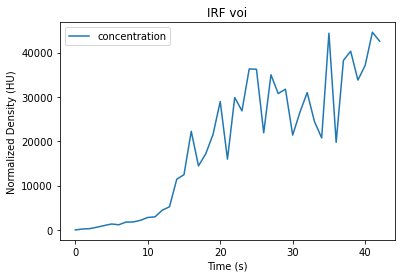

In [181]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik)/(1/example_voi))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [281]:
CBFs = np.zeros((pct_vals.shape[0],pct_vals.shape[1],pct_vals.shape[2]))
for cur_slice in range(CBFs.shape[2]):
    for i in range(CBFs.shape[0]):
        for j in range (CBFs.shape[1]):
            voi = pct_vals[i,j,cur_slice,:]
            #CBFs[i,j,cur_slice] = np.max(np.multiply(np.matmul(A,k),voi))
            CBFs[i,j,cur_slice],_ = signal.deconvolve(voi, k)

0.4991921737056459


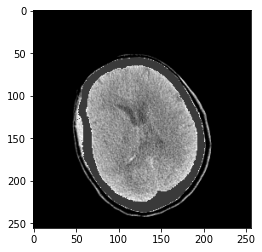

In [283]:
#tr = transforms.Affine2D().rotate_deg(50)
selected_slice = 0
img = CBFs[:,:,selected_slice]
print(np.max(img))
img[img > 0.3] = 0

#pp = img>0.005
#rotated_img = ndimage.rotate(, 45*60)
estimated_cbf = np.array(normalize_zero_one(img)*255,dtype = 'uint8')
rotated_img = ndimage.rotate(estimated_cbf, 90)

reflected_img = np.flip(rotated_img,axis=1)


plt.imshow(reflected_img,cmap=plt.cm.gray)
#plt.imshow(, transform=tr)

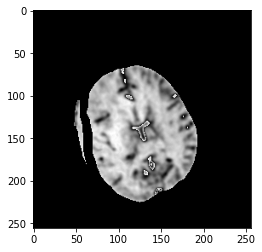

In [284]:
path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]

gt_cbf = nib.load(path_cbf).get_fdata()
gt_img = np.array(normalize_zero_one(gt_cbf[:,:,selected_slice])*255,dtype = 'uint8')
rotated_img = ndimage.rotate(gt_img, 90)
reflected_img = np.flip(rotated_img,axis=1)

plt.imshow(1-4*reflected_img,cmap=plt.cm.gray)

In [185]:
path_cbf

'/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_19/SMIR.Brain.XX.O.CT_CBF.339345/SMIR.Brain.XX.O.CT_CBF.339345.nii'

In [707]:
np.max(gt_cbf[:,:,selected_slice])

0.0

In [784]:
np.max(gt_cbf[:,:,selected_slice])

4402.0

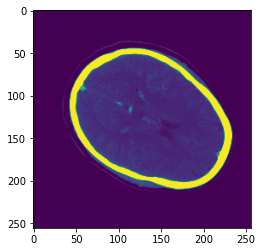

In [696]:
slice_7 = CBFs[:,:,7]
#slice_7[slice_7>1] = 0
rotated_img = ndimage.rotate(slice_7, 0)
plt.imshow(rotated_img)


In [ ]:
#%Calculate the CBF map
#cbfmap = scaling_factor * squeeze(max(rmap));


In [562]:
CBF = np.multiply(np.max(k_tik), 1/pct_vals)

In [563]:
pct_vals[pct_vals==0] = 0.000001

In [564]:
np.max(1/pct_vals[:,:,4])

1000000.0

In [565]:
CBF[CBF == inf] = 0

In [566]:
np.sum(CBF[:,:,0,:])

189016130000.0

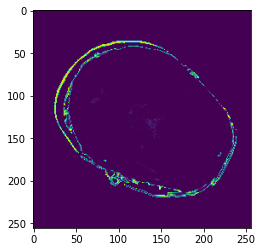

In [567]:
CBF_agregated = CBF.sum(axis=3)
normalized_CBF = normalize_zero_one(CBF_agregated)
normalized_CBF[normalized_CBF==1] = 0
normalized_CBF[normalized_CBF==0.28370348] = 0
plt.imshow(np.array(normalize_zero_one(normalized_CBF[:,:,1])*255, dtype='uint8'))

In [568]:
normalize_zero_one(CBF_agregated[:,:,5])

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [569]:
np.max(k_tik)

0.10646189112895685

Text(0, 0.5, 'Normalized Density (HU)')

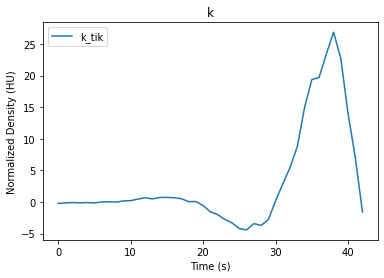

In [572]:
plt.title('k')        
plt.plot(-k)
#plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


Text(0, 0.5, 'Normalized Density (HU)')

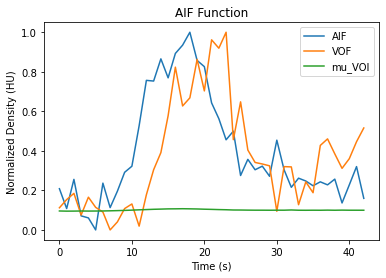

In [548]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot(y)
plt.plot(y_p)
plt.plot(mu_voi)
#plt.plot(k)
plt.legend(['AIF','VOF', 'mu_VOI', 'k'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [279]:
near_I = np.matmul(A,A_inv.T)
#near_I = np.matmul(A,pseudo_inv)

In [280]:
np.allclose(np.eye(near_I.shape[0]),near_I)

True

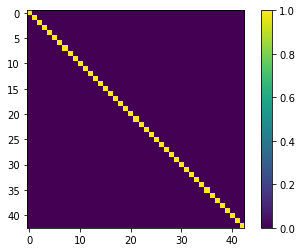

In [281]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(near_I)
plt.colorbar()
plt.show()

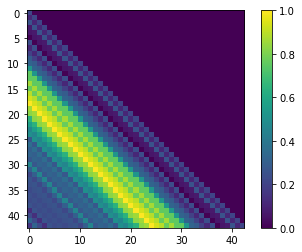

In [284]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(A)
plt.colorbar()
plt.show()